In [17]:
# AutoGluon Time Series - Forecasting with Debugging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# For AutoGluon
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Optional for improved visualizations
import seaborn as sns
sns.set_style('whitegrid')

In [18]:
from QuestradeAPI import QuestradeAPI, Chronos

# Initialize components
api = QuestradeAPI()  # Handles authentication automatically
chronos = Chronos(api=api)  # Data caching and persistence layer

## 1. Data Loading and Exploration


In [19]:
# Load your stock data
df = chronos.get_all_market_data() # Your data should be loaded here
df.info()
# Add a new column for the target variable
df['target'] = df['close']



Converted start column to dtype: datetime64[ns]
Converted end column to dtype: datetime64[ns]
Retrieved 301638 total candles across all symbols
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301638 entries, 0 to 301637
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   symbol    301638 non-null  object        
 1   start     301638 non-null  datetime64[ns]
 2   end       301638 non-null  datetime64[ns]
 3   low       301638 non-null  float64       
 4   high      301638 non-null  float64       
 5   open      301638 non-null  float64       
 6   close     301638 non-null  float64       
 7   volume    301638 non-null  int64         
 8   VWAP      301638 non-null  float64       
 9   interval  301638 non-null  object        
dtypes: datetime64[ns](2), float64(5), int64(1), object(2)
memory usage: 23.0+ MB


In [20]:
# TimeSeriesDataFrame can also be loaded directly from a file
exemple_test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")
exemple_train_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")


In [21]:
print(exemple_test_data.info())
print(exemple_train_data.info())

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 157660 entries, ('H1', Timestamp('1750-01-01 00:00:00')) to ('H200', Timestamp('1750-02-11 23:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  157660 non-null  float64
dtypes: float64(1)
memory usage: 1.9+ MB
None
<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 148060 entries, ('H1', Timestamp('1750-01-01 00:00:00')) to ('H200', Timestamp('1750-02-09 23:00:00'))
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   target  148060 non-null  float64
dtypes: float64(1)
memory usage: 1.7+ MB
None


In [22]:
# Filter the data to keep only OneMinute intervals
df = df[df['interval'] == 'OneMinute']

# Display the first few rows to verify the filtering
print("Filtered data (OneMinute intervals only):")
df


Filtered data (OneMinute intervals only):


,symbol,start,end,low,high,open,close,volume,VWAP,interval,target
0,AAPL,2024-12-23 09:28:00,2024-12-23 09:29:00,255.5900,255.5900,255.5900,255.59,232,255.577901,OneMinute,255.59
1,AAPL,2024-12-23 09:30:00,2024-12-23 09:31:00,255.4900,255.6100,255.5400,255.61,400,255.554710,OneMinute,255.61
2,AAPL,2024-12-23 09:34:00,2024-12-23 09:35:00,255.5200,255.5700,255.5700,255.52,810,255.559809,OneMinute,255.52
3,AAPL,2024-12-23 09:37:00,2024-12-23 09:38:00,255.6300,255.6300,255.6300,255.63,270,255.569315,OneMinute,255.63
4,AAPL,2024-12-23 09:38:00,2024-12-23 09:39:00,255.7300,255.7300,255.7300,255.73,100,255.580754,OneMinute,255.73
...,...,...,...,...,...,...,...,...,...,...,...
301633,TSLA,2025-03-21 23:56:00,2025-03-21 23:57:00,249.2715,249.4000,249.3285,249.40,1988,243.559906,OneMinute,249.40
301634,TSLA,2025-03-21 23:57:00,2025-03-21 23:58:00,249.3300,249.4000,249.3300,249.39,4665,243.560211,OneMinute,249.39
301635,TSLA,2025-03-21 23:58:00,2025-03-21 23:59:00,249.3600,249.4001,249.4000,249.40,4519,243.560576,OneMinute,249.40
301636,TSLA,2025-03-21 23:59:00,2025-03-22 00:00:00,249.4000,249.4900,249.4004,249.45,9445,243.561199,OneMinute,249.45


In [23]:
# Add financial indicators to the dataframe
import pandas as pd
import numpy as np

# Create a copy of the dataframe to avoid modifying the original
df_with_indicators = df.copy()

# Group by symbol to calculate indicators for each stock separately
for symbol in df_with_indicators['symbol'].unique():
    symbol_data = df_with_indicators[df_with_indicators['symbol'] == symbol].sort_values('start')
    
    # Moving Averages
    df_with_indicators.loc[symbol_data.index, 'MA_5'] = symbol_data['close'].rolling(window=5).mean()
    df_with_indicators.loc[symbol_data.index, 'MA_20'] = symbol_data['close'].rolling(window=20).mean()
    
    # Relative Strength Index (RSI)
    delta = symbol_data['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_with_indicators.loc[symbol_data.index, 'RSI'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    middle_band = symbol_data['close'].rolling(window=20).mean()
    std_dev = symbol_data['close'].rolling(window=20).std()
    df_with_indicators.loc[symbol_data.index, 'BB_Upper'] = middle_band + (std_dev * 2)
    df_with_indicators.loc[symbol_data.index, 'BB_Lower'] = middle_band - (std_dev * 2)
    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = symbol_data['close'].ewm(span=12, adjust=False).mean()
    ema_26 = symbol_data['close'].ewm(span=26, adjust=False).mean()
    df_with_indicators.loc[symbol_data.index, 'MACD'] = ema_12 - ema_26
    df_with_indicators.loc[symbol_data.index, 'MACD_Signal'] = (ema_12 - ema_26).ewm(span=9, adjust=False).mean()
    
    # Average True Range (ATR)
    high_low = symbol_data['high'] - symbol_data['low']
    high_close = abs(symbol_data['high'] - symbol_data['close'].shift())
    low_close = abs(symbol_data['low'] - symbol_data['close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df_with_indicators.loc[symbol_data.index, 'ATR'] = true_range.rolling(window=14).mean()

# Replace the original dataframe with the one containing indicators
df = df_with_indicators

# Display the first few rows to verify the indicators were added
print("Data with financial indicators:")
df.head()


Data with financial indicators:


,symbol,start,end,low,high,open,close,volume,VWAP,interval,target,MA_5,MA_20,RSI,BB_Upper,BB_Lower,MACD,MACD_Signal,ATR
0,AAPL,2024-12-23 09:28:00,2024-12-23 09:29:00,255.59,255.59,255.59,255.59,232,255.577901,OneMinute,255.59,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,AAPL,2024-12-23 09:30:00,2024-12-23 09:31:00,255.49,255.61,255.54,255.61,400,255.554710,OneMinute,255.61,NaN,NaN,NaN,NaN,NaN,0.001595,0.000319,NaN
2,AAPL,2024-12-23 09:34:00,2024-12-23 09:35:00,255.52,255.57,255.57,255.52,810,255.559809,OneMinute,255.52,NaN,NaN,NaN,NaN,NaN,-0.004352,-0.000615,NaN
3,AAPL,2024-12-23 09:37:00,2024-12-23 09:38:00,255.63,255.63,255.63,255.63,270,255.569315,OneMinute,255.63,NaN,NaN,NaN,NaN,NaN,-0.000188,-0.000530,NaN
4,AAPL,2024-12-23 09:38:00,2024-12-23 09:39:00,255.73,255.73,255.73,255.73,100,255.580754,OneMinute,255.73,255.616,NaN,NaN,NaN,NaN,0.011055,0.001787,NaN


In [24]:
# Convert the DataFrame to a TimeSeriesDataFrame format required by AutoGluon
# We need to set up a MultiIndex with (item_id, timestamp)
from autogluon.timeseries import TimeSeriesDataFrame

# Create a copy of the dataframe to avoid modifying the original
df_ts = df.copy()

# Rename columns to match AutoGluon's expected format
df_ts = df_ts.rename(columns={'symbol': 'item_id', 'start': 'timestamp'})

# Set the MultiIndex with item_id and timestamp
df_ts = df_ts.set_index(['item_id', 'timestamp'])

# Drop the 'end' column as it's not needed for forecasting
df_ts = df_ts.drop(columns=['end'])

# Convert to TimeSeriesDataFrame format
ts_data = TimeSeriesDataFrame(df_ts)

# Define prediction length
prediction_length = 60

# Create testing dataset (all data)
test_data = ts_data.copy()

# Create training dataset by excluding the last prediction_length points for each item_id
train_data = TimeSeriesDataFrame.from_data_frame(
    pd.concat([
        group.iloc[:-prediction_length] 
        for item_id, group in ts_data.groupby('item_id')
    ]),
    id_column='item_id',
    timestamp_column='timestamp'
)

# Print information about the datasets
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

# Verify the data structure
print("\nTraining data info:")
print(train_data.info())

print("\nTesting data info:")
print(test_data.info())

# Display the first few rows of the training data
print("\nTraining data sample:")
train_data.head()


Training data shape: (301218, 16)
Testing data shape: (301638, 16)

Training data info:
<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 301218 entries, ('AAPL', Timestamp('2024-12-23 09:28:00')) to ('TSLA', Timestamp('2025-03-21 23:00:00'))
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   low          301218 non-null  float64
 1   high         301218 non-null  float64
 2   open         301218 non-null  float64
 3   close        301218 non-null  float64
 4   volume       301218 non-null  int64  
 5   VWAP         301218 non-null  float64
 6   interval     301218 non-null  object 
 7   target       301218 non-null  float64
 8   MA_5         301190 non-null  float64
 9   MA_20        301085 non-null  float64
 10  RSI          301127 non-null  float64
 11  BB_Upper     301085 non-null  float64
 12  BB_Lower     301085 non-null  float64
 13  MACD         301218 non-null  float64
 1

low    high    open   close  volume  \
item_id timestamp                                                     
AAPL    2024-12-23 09:28:00  255.59  255.59  255.59  255.59     232   
        2024-12-23 09:30:00  255.49  255.61  255.54  255.61     400   
        2024-12-23 09:34:00  255.52  255.57  255.57  255.52     810   
        2024-12-23 09:37:00  255.63  255.63  255.63  255.63     270   
        2024-12-23 09:38:00  255.73  255.73  255.73  255.73     100   

                                   VWAP   interval  target     MA_5  MA_20  \
item_id timestamp                                                            
AAPL    2024-12-23 09:28:00  255.577901  OneMinute  255.59      NaN    NaN   
        2024-12-23 09:30:00  255.554710  OneMinute  255.61      NaN    NaN   
        2024-12-23 09:34:00  255.559809  OneMinute  255.52      NaN    NaN   
        2024-12-23 09:37:00  255.569315  OneMinute  255.63      NaN    NaN   
        2024-12-23 09:38:00  255.580754  OneMinute  255.73  255.616    NaN   

                             RSI  BB_Upper  BB_Lower      MACD  MACD_Signal  \
item_id timestamp                                                             
AAPL    2024-12-23 09:28:00  NaN       NaN       NaN  0.000000     0.000000   
        2024-12-23 09:30:00  NaN       NaN       NaN  0.001595     0.000319   
        2024-12-23 09:34:00  NaN       NaN       NaN -0.004352    -0.000615   
        2024-12-23 09:37:00  NaN       NaN       NaN -0.000188    -0.000530   
        2024-12-23 09:38:00  NaN       NaN       NaN  0.011055     0.001787   

                             ATR  
item_id timestamp                 
AAPL    2024-12-23 09:28:00  NaN  
        2024-12-23 09:30:00  NaN  
        2024-12-23 09:34:00  NaN  
        2024-12-23 09:37:00  NaN  
        2024-12-23 09:38:00  NaN

In [25]:
test_data

low      high      open   close  volume  \
item_id timestamp                                                           
AAPL    2024-12-23 09:28:00  255.5900  255.5900  255.5900  255.59     232   
        2024-12-23 09:30:00  255.4900  255.6100  255.5400  255.61     400   
        2024-12-23 09:34:00  255.5200  255.5700  255.5700  255.52     810   
        2024-12-23 09:37:00  255.6300  255.6300  255.6300  255.63     270   
        2024-12-23 09:38:00  255.7300  255.7300  255.7300  255.73     100   
...                               ...       ...       ...     ...     ...   
TSLA    2025-03-21 23:56:00  249.2715  249.4000  249.3285  249.40    1988   
        2025-03-21 23:57:00  249.3300  249.4000  249.3300  249.39    4665   
        2025-03-21 23:58:00  249.3600  249.4001  249.4000  249.40    4519   
        2025-03-21 23:59:00  249.4000  249.4900  249.4004  249.45    9445   
        2025-03-22 00:00:00  249.4500  249.4500  249.4500  249.45     200   

                                   VWAP   interval  target       MA_5  \
item_id timestamp                                                       
AAPL    2024-12-23 09:28:00  255.577901  OneMinute  255.59        NaN   
        2024-12-23 09:30:00  255.554710  OneMinute  255.61        NaN   
        2024-12-23 09:34:00  255.559809  OneMinute  255.52        NaN   
        2024-12-23 09:37:00  255.569315  OneMinute  255.63        NaN   
        2024-12-23 09:38:00  255.580754  OneMinute  255.73  255.61600   
...                                 ...        ...     ...        ...   
TSLA    2025-03-21 23:56:00  243.559906  OneMinute  249.40  249.23162   
        2025-03-21 23:57:00  243.560211  OneMinute  249.39  249.29962   
        2025-03-21 23:58:00  243.560576  OneMinute  249.40  249.32800   
        2025-03-21 23:59:00  243.561199  OneMinute  249.45  249.38800   
        2025-03-22 00:00:00  243.561199  OneMinute  249.45  249.41800   

                                  MA_20        RSI    BB_Upper    BB_Lower  \
item_id timestamp                                                            
AAPL    2024-12-23 09:28:00         NaN        NaN         NaN         NaN   
        2024-12-23 09:30:00         NaN        NaN         NaN         NaN   
        2024-12-23 09:34:00         NaN        NaN         NaN         NaN   
        2024-12-23 09:37:00         NaN        NaN         NaN         NaN   
        2024-12-23 09:38:00         NaN        NaN         NaN         NaN   
...                                 ...        ...         ...         ...   
TSLA    2025-03-21 23:56:00  249.101970  62.888496  249.441728  248.762212   
        2025-03-21 23:57:00  249.107470  63.355097  249.462578  248.752362   
        2025-03-21 23:58:00  249.107655  67.608389  249.463399  248.751911   
        2025-03-21 23:59:00  249.116155  74.349170  249.496511  248.735799   
        2025-03-22 00:00:00  249.129155  70.821766  249.536923  248.721387   

                                 MACD  MACD_Signal       ATR  
item_id timestamp                                             
AAPL    2024-12-23 09:28:00  0.000000     0.000000       NaN  
        2024-12-23 09:30:00  0.001595     0.000319       NaN  
        2024-12-23 09:34:00 -0.004352    -0.000615       NaN  
        2024-12-23 09:37:00 -0.000188    -0.000530       NaN  
        2024-12-23 09:38:00  0.011055     0.001787       NaN  
...                               ...          ...       ...  
TSLA    2025-03-21 23:56:00 -0.043496    -0.104235  0.140371  
        2025-03-21 23:57:00 -0.021952    -0.087779  0.132029  
        2025-03-21 23:58:00 -0.004025    -0.071028  0.122036  
        2025-03-21 23:59:00  0.014055    -0.054011  0.119893  
        2025-03-22 00:00:00  0.028060    -0.037597  0.109179  

[301638 rows x 16 columns]

In [11]:
predictor = TimeSeriesPredictor(
    prediction_length=prediction_length,
    path="../models/test",
    target="target",
    eval_metric="RMSE",
    freq="min",
)

predictor.fit(
    train_data,
    presets="fast_training",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'c:\Users\yaloo\QuestradeCustomWrapper\models\test'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.4
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          22
GPU Count:          0
Memory Avail:       2.68 GB / 15.37 GB (17.4%)
Disk Space Avail:   517.62 GB / 951.93 GB (54.4%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'min',
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 60,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'min'.

In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

data with frequency 'None' has been resampled to frequency 'min'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
AAPL    2025-03-21 22:02:00  217.644758  215.001313  215.908753  216.563081   
        2025-03-21 22:03:00  217.644758  213.944494  215.214718  216.130639   
        2025-03-21 22:04:00  217.635470  213.124279  214.672878  215.789526   
        2025-03-21 22:05:00  217.635470  212.440637  214.223916  215.509785   
        2025-03-21 22:06:00  217.635470  211.838336  213.828372  215.263328   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
AAPL    2025-03-21 22:02:00  217.122180  217.644756  218.167333  218.726432   
        2025-03-21 22:03:00  216.913259  217.644756  218.376253  219.158874   
        2025-03-21 22:04:00  216.743661  217.635468  218.527275  219.481409   
        2025-03-21 22:05:00  216.608513  217.635468  218.662422  219.761150   
        2025-03-21 22:06:00  216.489446  217.635468  218.781490  220.007607   

                                    0.8         0.9  
item_id timestamp                                    
AAPL    2025-03-21 22:02:00  219.380760  220.288200  
        2025-03-21 22:03:00  220.074795  221.345019  
        2025-03-21 22:04:00  220.598058  222.146656  
        2025-03-21 22:05:00  221.047020  222.830298  
        2025-03-21 22:06:00  221.442563  223.432599

data with frequency 'None' has been resampled to frequency 'min'.


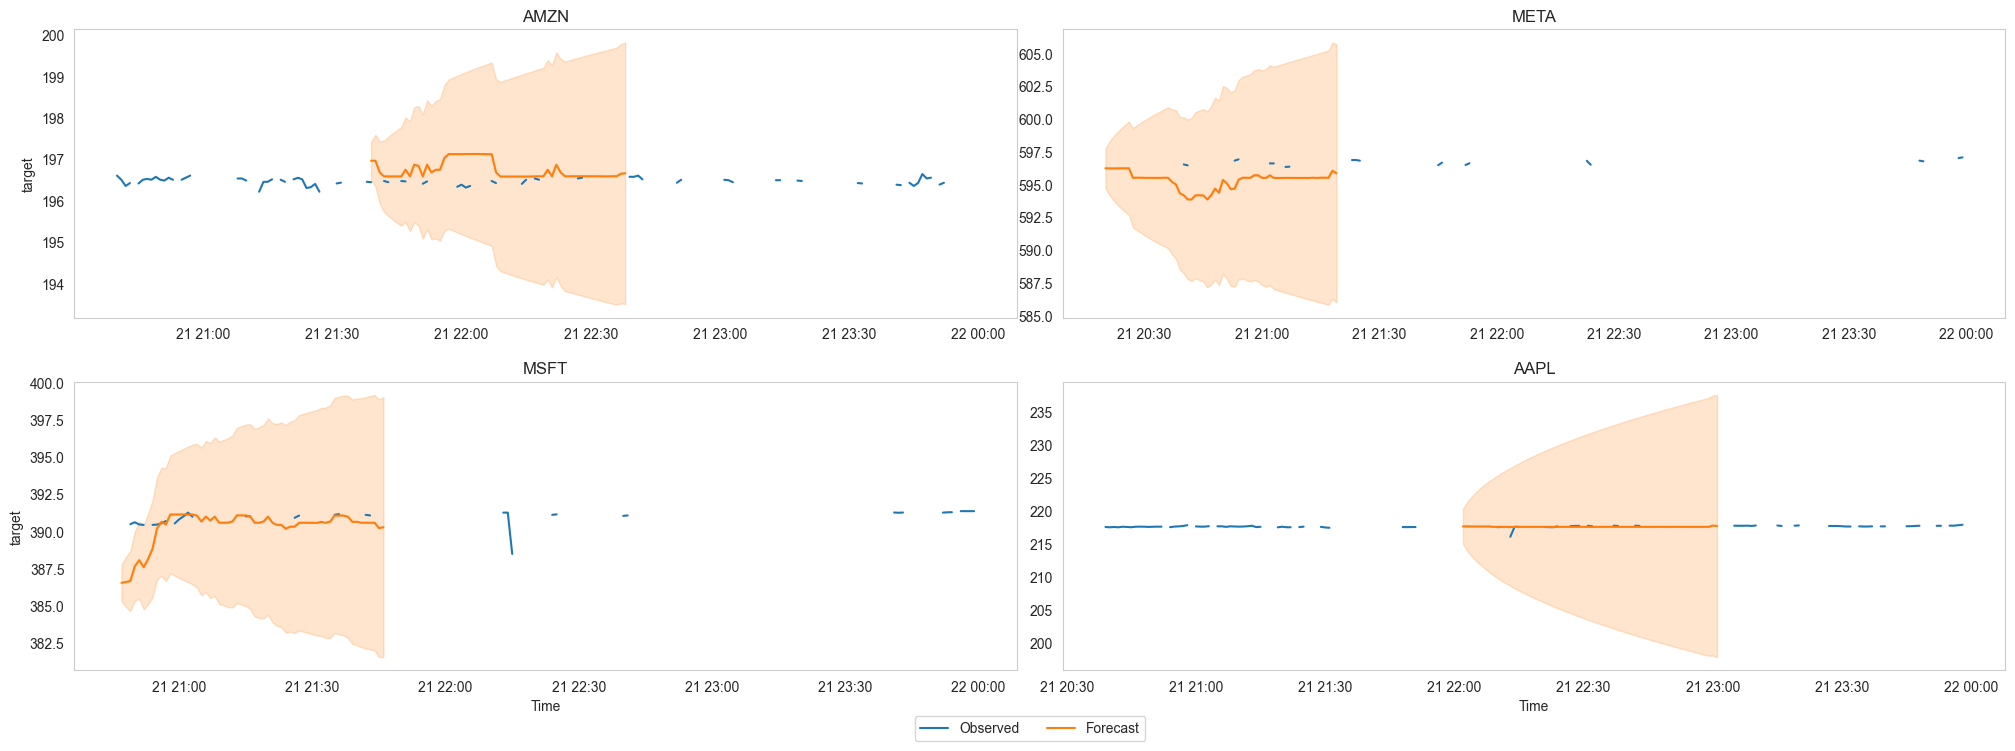

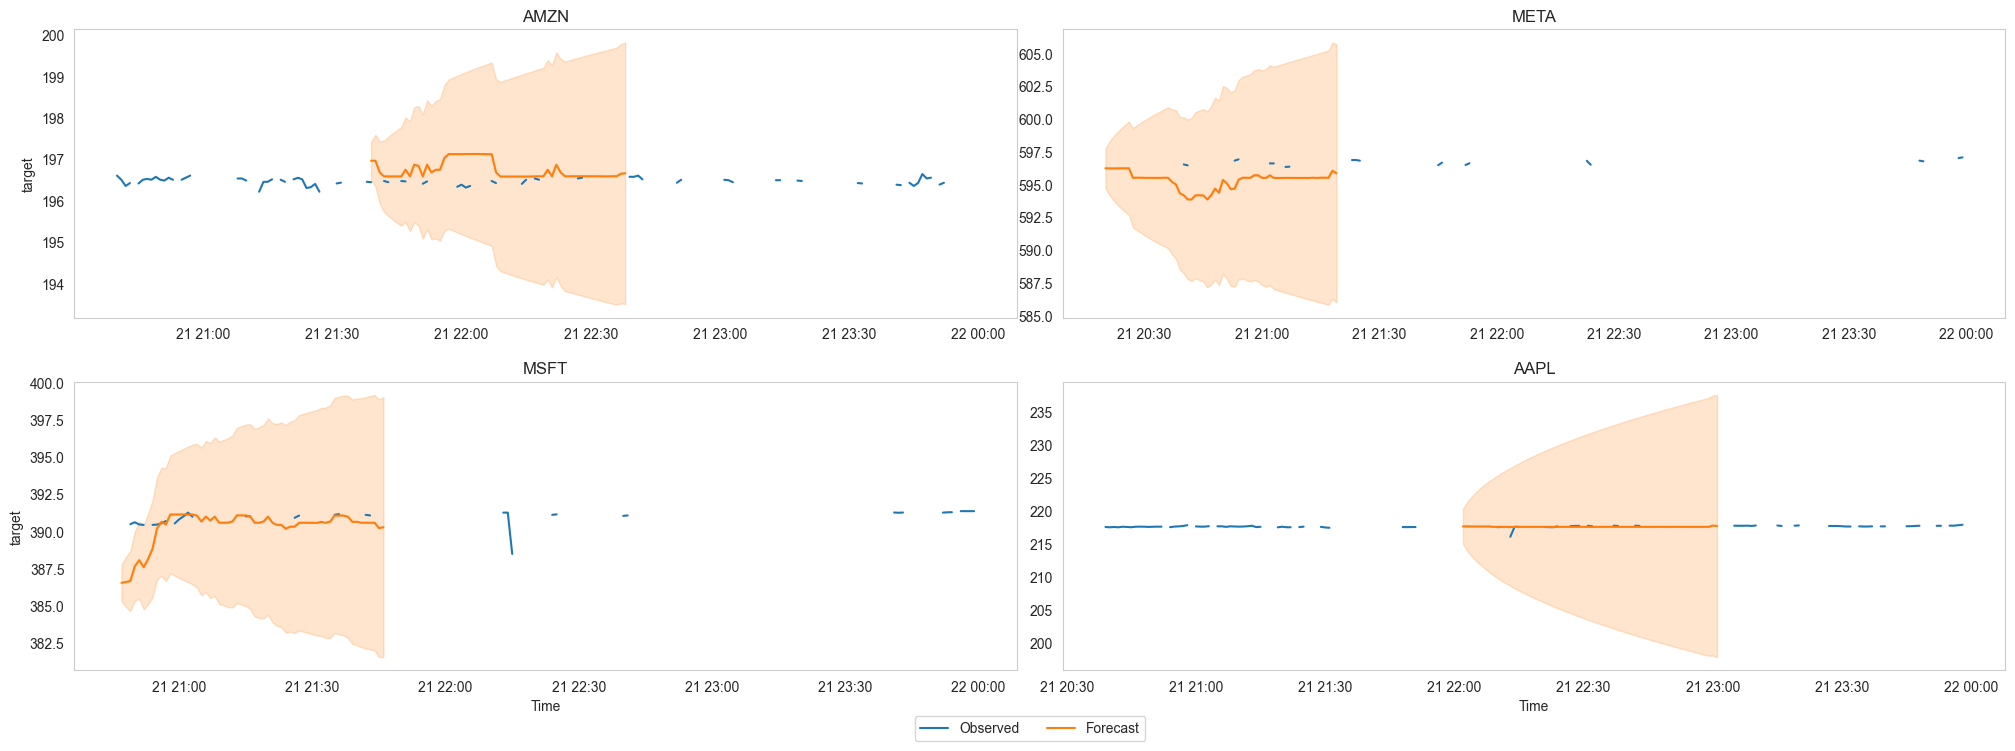

In [ ]:
# Plot 4 randomly chosen time series and the respective forecasts
plot_data = predictor.plot(test_data, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4);
plot_data 


In [507]:
# The test score is computed using the last
# prediction_length=48 timesteps of each time series in test_data
predictor.leaderboard(test_data)

data with frequency 'None' has been resampled to frequency 'min'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,TemporalFusionTransformer,-0.131995,-0.111475,0.696229,0.628705,238.640118,8
1,WeightedEnsemble,-0.132941,-0.099809,35.459893,30.878674,0.679197,9
2,Theta,-0.182392,-0.113845,26.246718,24.807649,0.890846,6
3,ETS,-0.191246,-0.113594,6.348355,2.471611,0.985934,5
4,Naive,-0.194267,-0.113844,0.129062,3.563026,0.697767,1
5,RecursiveTabular,-0.223181,-0.187644,1.343222,1.297733,13.012852,3
6,Chronos[bolt_small],-0.407634,-0.435448,0.823368,1.672975,7.586669,7
7,DirectTabular,-0.628332,-0.567005,3.829431,2.635226,13.535440,4
8,SeasonalNaive,-7.542092,-6.468332,2.457947,2.566603,0.671196,2
